In [11]:
import numpy as np
import cv2 as cv
import napari
import os
import matplotlib.pyplot as plt

In [62]:
# function definitions

def visualize_napari(images, labels):
    """ Visualize all images in list using napari
    parameters
    ----------
    imagest: list of numpy images
    labels: list of names for each image
        """
    viewer = napari.Viewer()
    for i, img in enumerate(images):
        viewer.add_image(img, name=labels[i])

def clean_stats(labels, stats, centroids):
    """
    Delete connected components that are too small or too large.
    """
    labels_cp = labels.copy()
    stats_cp = stats.copy()
    centroids_cp = centroids.copy()
    indices = []

    for i in range(0, stats.shape[0]):
        if stats[i, 4] < np.pi*30**2:
            indices.append(i)
        elif stats[i,2] > 450 or stats[i,3] > 450 or not(0.75 <= stats[i,2]/stats[i,3] <= 1.33):
            indices.append(i)
        elif np.min(np.where(labels == i)[0]) == 0 or np.min(np.where(labels == i)[1]) == 0 \
            or np.max(np.where(labels == i)[0]) == labels.shape[0]-1 or np.max(np.where(labels == i)[1]) == labels.shape[1]-1:
            indices.append(i)
    
    labels_cp = labels_cp * ~(np.in1d(labels_cp, indices).reshape(labels_cp.shape))
    stats_cp = np.delete(stats_cp, indices, axis=0)
    centroids_cp = np.delete(centroids_cp, indices, axis=0)
    return labels_cp, stats_cp, centroids_cp

def add_bounding_boxes(img, stats, labels, centroids):
    """
    Add rectangles around objects
    """
    labels_cp = labels.copy()
    stats_cp = stats.copy()
    centroids_cp = centroids.copy()
    indices = []
    img_copy = img.copy()
    
    for i in range(0, stats.shape[0]):
        # discard component if too small indicating noise or holes within components
        if stats[i, 4] < np.pi*30**2:
            indices.append(i)
            continue
        # color box red if component is taking up too much space or enclosing rectangle is too elongated
        # indicating >=2 cells being attached to each other
        # elif stats[i, 4] > np.pi*300**2 or not(0.7 <= stats[i,2] / stats[i,3] <= 1.3):
        elif stats[i,2] > 450 or stats[i,3] > 450 or not(0.75 <= stats[i,2]/stats[i,3] <= 1.33):
            indices.append(i)
            x = stats[i, 0] - 20
            y = stats[i, 1] - 20
            w = stats[i, 2] + 40
            h = stats[i, 3] + 40
            cv.rectangle(img_copy, (x, y), (x + w, y + h), (0, 0, 255), 3)
        # discard component if at boundary
        elif np.min(np.where(labels == i)[0]) == 0 or np.min(np.where(labels == i)[1]) == 0 \
            or np.max(np.where(labels == i)[0]) == labels.shape[0]-1 or np.max(np.where(labels == i)[1]) == labels.shape[1]-1:
            indices.append(i)
            x = stats[i, 0] - 20
            y = stats[i, 1] - 20
            w = stats[i, 2] + 40
            h = stats[i, 3] + 40
            cv.rectangle(img_copy, (x, y), (x + w, y + h), (0, 0, 255), 3)
        # else, color box green
        else:
            x = stats[i, 0] - 20
            y = stats[i, 1] - 20
            w = stats[i, 2] + 40
            h = stats[i, 3] + 40
            cv.rectangle(img_copy, (x, y), (x + w, y + h), (0, 255, 0), 3)
    
    labels_cp = labels_cp * ~(np.in1d(labels_cp, indices).reshape(labels_cp.shape))
    stats_cp = np.delete(stats_cp, indices, axis=0)
    centroids_cp = np.delete(centroids_cp, indices, axis=0)
    return img_copy, labels_cp, stats_cp, centroids_cp


def find_enclosing_ellipses(img, labels):
    """
    Find and add enclosing ellipses around objects
    ----------
    labels: contains only labels of "valid" components
    """
    img_copy = img.copy()
    d = []
    area = []

    for i in np.unique(labels)[1:]:
        # set of points of object
        points = np.where(labels == i)
        points = np.transpose(points)

        # find minimal bounding rectangle, possibly rotated
        (xc, yc), (d1, d2), angle = cv.minAreaRect(points)

        # save diameters and area
        d.append((min(d1, d2), max(d1, d2)))
        area.append(np.pi*(d1/2)*(d2/2))

        # add bounding ellipse around objects
        ellipse = ((int(yc), int(xc)), (int(d2), int(d1)), -angle)
        cv.ellipse(img_copy, ellipse, (255, 255, 0), 3)
    return img_copy, np.array(d), np.array(area)



In [60]:
np.pi*30**2

2827.4333882308138

In [114]:
# iterate through all filenames in folder 'DE_annotated_pictures'

# path to folder containing images
path = 'base_model_pictures'

# list of all filenames in folder
filenames = os.listdir(path)

kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (4,4))
a = []

# iterate through all filenames
for filename in filenames:
    # path to image
    file = os.path.join(path, filename)
    print(file)

    # read image
    img = cv.imread(file)

    # convert image to grayscale
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # cv.imwrite('base_model_masking/' + file.split('\\')[1].split('.')[0] + '_gray.tif', gray)

    # binarize image applying global thresholding
    _, thresh = cv.threshold(gray, np.mean(gray) + np.sqrt(np.sqrt(np.std(gray))), 255, cv.THRESH_BINARY_INV)

    # erode boundary to detach objects
    erosion = cv.erode(thresh, kernel, iterations = 5)
    cv.imwrite('base_model_masking/' + file.split('\\')[1].split('.')[0] + '_erosion.tif', erosion)

    # compute connected components and corresponding stats
    num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(erosion, connectivity=8)

    # add bounding boxes around objects and correct stats for neglected objects
    img_with_boxes, tlabels, tstats, tcentroids = add_bounding_boxes(img, stats, labels, centroids)
    cv.imwrite('base_model_masking/' + file.split('\\')[1].split('.')[0] + '_boxes.tif', img_with_boxes)

    # add enclosing ellipses
    img_with_ellipses, axes_lengths, area = find_enclosing_ellipses(img, tlabels)
    a.append(area)
    cv.imwrite('base_model_masking/' + file.split('\\')[1].split('.')[0] + '_ellipses.tif', img_with_ellipses)

    # # scatterplot of (ma, MA) 
    # plt.plot([0,500], [0,500])
    # plt.scatter(axes_lengths[:,0], axes_lengths[:,1])
    # plt.xlabel('minor axis length')
    # plt.ylabel('major axis length')
    # plt.title(file.split('\\')[1].split('.')[0])
    # plt.show()

    # images = [img, gray, thresh, erosion, img_with_boxes, img_with_ellipses]
    # labels = ['img', 'gray', 'thresh', 'erosion', 'img_with_boxes', 'img_with_ellipses']
    # visualize_napari(images, labels)
    
    

base_model_pictures\20220130_543_D4001_ch00_nn.tif
base_model_pictures\20220302_EXP592_100ML_DAY4002_ch00_yn.tif
base_model_pictures\20220302_EXP593_50ML_DAY4001_ch00_yn.tif
base_model_pictures\20220329_Exp 639 day 4_ch00_yy.tif
base_model_pictures\20220505_681 day 4002_ch00_yy.tif
base_model_pictures\20220528_702 D4001_ch00_yn.tif
base_model_pictures\20220528_703 D4 001_ch00_yn.tif
base_model_pictures\20220528_704 D4 001_ch00_yn.tif
base_model_pictures\20220528_705 D4 001_ch00_yn.tif
base_model_pictures\20220529_709 D4001_ch00_yy.tif
base_model_pictures\20220604_711 day 4001_ch00_yy.tif
base_model_pictures\20220604_712 day 4001_ch00_yy.tif
base_model_pictures\20220604_713 day 4001_ch00_yy.tif
base_model_pictures\20220611_720 DE001_ch00_yy.tif
base_model_pictures\20220616_725 D4001_ch00_yy.tif
base_model_pictures\20220703_740 day 4001_ch00_yy.tif
base_model_pictures\20220806_776 day 4002_ch00_yy.tif
base_model_pictures\20220918_808 D4001_ch00_yn.tif
base_model_pictures\20220918_809 D40

In [113]:
# path to folder containing images
path = 'base_model_pictures'

# list of all filenames in folder
filenames = os.listdir(path)

kernel1 = cv.getStructuringElement(cv.MORPH_RECT, (2,2))
kernel2 = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3,3))

viewer = napari.Viewer()

# iterate through all filenames
for filename in filenames:
    # path to image
    file = os.path.join(path, filename)

    # read image
    img = cv.imread(file)
    # viewer.add_image(img, name=file.split('\\')[1].split('.')[0])

    # convert image to grayscale
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # viewer.add_image(gray, name=file.split('\\')[1].split('.')[0] + '_gray')

    # binarize image applying global thresholding
    blur = cv.GaussianBlur(gray,(5,5),0)
    _, thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
    viewer.add_image(thresh, name=file.split('\\')[1].split('.')[0] + '_thresh')

    # opening = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel1)
    closing = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel1)

    # detach objects using morphological operations
    erosion = cv.erode(thresh, kernel2, iterations = 7)
    viewer.add_image(erosion, name=file.split('\\')[1].split('.')[0] + '_erosion')

In [81]:
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3,3))
kernel

array([[0, 1, 0],
       [1, 1, 1],
       [0, 1, 0]], dtype=uint8)

In [31]:
img.shape

(1944, 2592, 3)

In [44]:
name = filenames[0]
name.split('.')[0][-2:] == 'nn'

True

In [115]:
# divide a into three lists depending on suffix yy, yn or nn
a_yy = []
a_yn = []
a_nn = []

for i in range(len(a)):
    if filenames[i].split('.')[0][-2:] == 'yy':
        a_yy.append(a[i])
    elif filenames[i].split('.')[0][-2:] == 'yn':
        a_yn.append(a[i])
    else:
        a_nn.append(a[i])


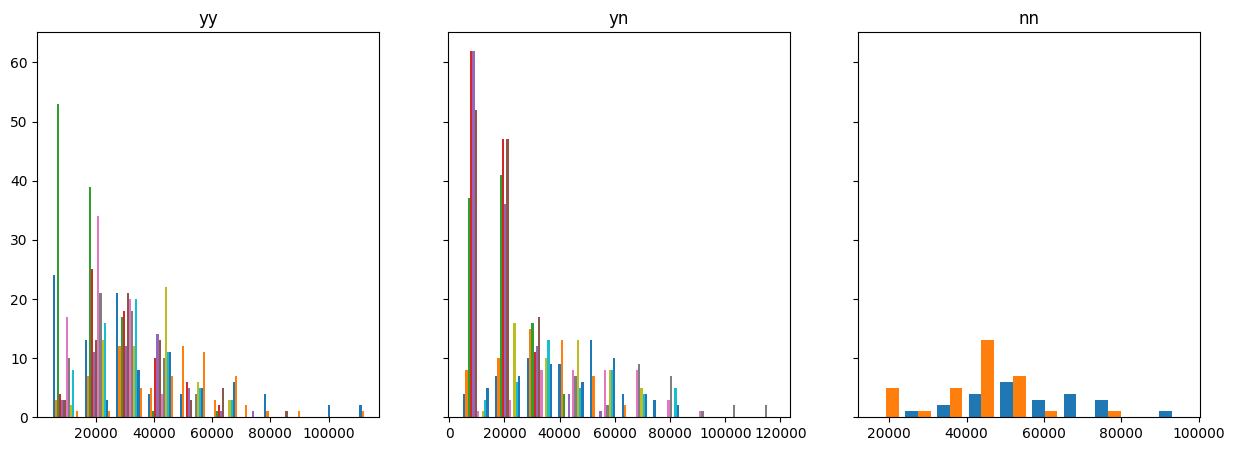

In [116]:
# plot histograms of a_yy, a_yn and a_nn in separate subplots
# increase figure size 
plt.rcParams['figure.figsize'] = [15, 5]
fig, axs = plt.subplots(1, 3, sharey=True)
axs[0].hist(a_yy)
axs[0].set_title('yy')
axs[1].hist(a_yn)
axs[1].set_title('yn')
axs[2].hist(a_nn)
axs[2].set_title('nn')
plt.show()

In [117]:
for item in a:
    print(max(item))

97132.26338261827
78112.89846406733
72821.32677416138
55046.132019448574
78613.70929490175
45987.93728480444
35401.66258822848
52611.31518030399
37609.9439408485
63113.121306768546
63432.64448225507
73413.69105140073
80853.74390963007
44799.22300191202
52602.940116862286
65717.80890374248
67705.56058103211
86400.58838702561
112701.40628044825
113115.45421618246
118815.51825104923
67788.03108614146
83479.35719808156
79930.70747317497
76159.52394809734


In [ ]:
paths = ['DE_annotated_pictures/20220918_809 D4001_ch00_yy.tif',
         'DE_annotated_pictures/20220918_811 D4001_ch00_yn.tif',
         'DE_annotated_pictures/20220130_543_D4001_ch00_nn.tif']

kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (4,4))

# data = np.empty(shape=[0, 2])
colors = ['red', 'green', 'blue']
a = []

for idx, path in enumerate(paths):
    # read image
    img = cv.imread(path)

    # convert image to grayscale
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # cv.imwrite(path.split('/')[1].split('.')[0] + '_gray.tif', gray)

    # binarize image applying global thresholding
    _, thresh = cv.threshold(gray, np.mean(gray), 255, cv.THRESH_BINARY_INV)

    # erode boundary to detach objects
    erosion = cv.erode(thresh, kernel, iterations = 5)
    # cv.imwrite(path.split('/')[1].split('.')[0] + '_erosion.tif',erosion)

    # compute connected components and corresponding stats
    num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(erosion, connectivity=8)

    # add bounding boxes around objects and correct stats for neglected objects
    img_with_boxes, tlabels, tstats, tcentroids = add_bounding_boxes(img, stats, labels, centroids)
    # cv.imwrite(path.split('/')[1].split('.')[0] + '_boxes.tif', img_with_boxes)

    # add enclosing ellipses
    img_with_ellipses, axes_lengths, area = find_enclosing_ellipses(img, tlabels)
    a.append(area)
    # cv.imwrite(path.split('/')[1].split('.')[0] + '_ellipses.tif', img_with_ellipses)

    # scatterplot of (ma, MA) 
    plt.plot([0,430], [0,430])
    plt.scatter(axes_lengths[:,0], axes_lengths[:,1])
    plt.xlim((150,430))
    plt.ylim((150,430))
    plt.xlabel('minor axis length')
    plt.ylabel('major axis length')
    plt.title(path.split('/')[1].split('.')[0])
    plt.show()

    images = [img, gray, thresh, erosion, img_with_boxes, img_with_ellipses]
    labels = ['img', 'gray', 'thresh', 'erosion', 'img_with_boxes', 'img_with_ellipses']
    # visualize_napari(images, labels)

In [3]:
# img = cv.imread('DE_annotated_pictures/20220202_547 D4 001_ch00_yn.tif')
img = cv.imread('DE_annotated_pictures/20220918_812 100ml D4001_ch00_yn.tif')
# viewer = napari.Viewer()
# viewer.add_image(img, rgb=True)

In [223]:
img1 = cv.imread('DE_annotated_pictures/20220528_703 D4 001_ch00_yn.tif')
img2 = cv.imread('DE_annotated_pictures/20220918_811 D4001_ch00_yn.tif')
print(img1.shape, img2.shape)
viewer = napari.Viewer()
viewer.add_image(img1)
viewer.add_image(img2)

(1944, 2592, 3) (1944, 2592, 3)


<Image layer 'img2' at 0x2ed6440d0c0>

In [4]:
gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
# viewer.add_image(gray_img)

In [34]:
low = np.array([0, 0, 0])
high = np.array([200, 180, 105])
mask_inRange = cv.inRange(img, low, high)
masked_img = cv.bitwise_and(img, img, mask=mask_inRange)
# viewer.add_image(mask_inRange)

In [24]:
twoDimage = img.reshape((-1,3))
twoDimage = np.float32(twoDimage)

In [25]:
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
attempts = 10

ret1, label1, center1 = cv.kmeans(twoDimage, 2, None, criteria, attempts, cv.KMEANS_PP_CENTERS)
ret2, label2, center2 = cv.kmeans(twoDimage, 3, None, criteria, attempts, cv.KMEANS_PP_CENTERS)
ret3, label3, center3 = cv.kmeans(twoDimage, 4, None, criteria, attempts, cv.KMEANS_PP_CENTERS)

center1 = np.uint8(center1)
res1 = center1[label1.flatten()]
mask_2nn = res1.reshape((img.shape))

center2 = np.uint8(center2)
res2 = center2[label2.flatten()]
mask_3nn = res2.reshape((img.shape))

center3 = np.uint8(center3)
res3 = center3[label3.flatten()]
mask_4nn = res3.reshape((img.shape))

# viewer.add_image(mask_2nn)
# viewer.add_image(mask_3nn)
# viewer.add_image(mask_4nn)

In [5]:
_, thresh = cv.threshold(gray_img, np.mean(gray_img), 255, cv.THRESH_BINARY_INV)
edges = cv.dilate(cv.Canny(thresh, 0, 255), None)

In [6]:
kernel1 = cv.getStructuringElement(cv.MORPH_RECT, (3,3))
kernel2 = cv.getStructuringElement(cv.MORPH_ELLIPSE, (4,4))

erosion = cv.erode(thresh, kernel2, iterations = 5)
opening = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel2)
closing = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel2)
dilation = cv.dilate(thresh, kernel2, iterations = 1)

In [248]:
viewer = napari.Viewer()
viewer.add_image(img)
viewer.add_image(thresh)
viewer.add_image(erosion)
# viewer.add_image(opening) 
# viewer.add_image(closing)
# viewer.add_image(dilation)

<Image layer 'erosion' at 0x2ed4b8dbfa0>

In [131]:
thresh_adpt_m = cv.adaptiveThreshold(gray_img, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 25, 10)
thresh_adpt_g = cv.adaptiveThreshold(gray_img, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, -10)
dilation = cv.dilate(thresh_adpt_m, kernel1, iterations = 1)
opening = cv.morphologyEx(thresh_adpt_m, cv.MORPH_OPEN, kernel1)

In [148]:
viewer = napari.Viewer()
viewer.add_image(thresh_adpt_m)
viewer.add_image(dilation)
viewer.add_image(opening)
viewer.add_image(img)

<Image layer 'img' at 0x2ed34103bb0>

In [39]:
from skimage.filters import threshold_otsu

th_otsu = threshold_otsu(gray_img)
thresh_otsu  = gray_img < th_otsu

# viewer.add_image(img_otsu)

In [44]:
imgs = [img, gray_img, mask_inRange, thresh, opening, closing, dilation, thresh_adpt_m, thresh_adpt_g, thresh_otsu]
labels = ['original', 'grayscale', 'color masking', 'global thresholding', 
          'opening', 'opened and closed', 'opened and dilated',
          'adaptive mean thresholding', 'adpative gaussian thresholding', 'otsu thresholding']
print(len(imgs), len(labels))
visualize_napari(imgs, labels)

10 10


In [7]:
num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(erosion, connectivity=8)

In [251]:
tlabels, tstats, tcentroids = clean_stats(labels, stats, centroids)

In [252]:
tstats.shape

(57, 5)

In [19]:
img.shape

(1944, 2592, 3)

In [21]:
img_with_boxes, tlabels, tstats, tcentroids = add_bounding_boxes(img, stats, labels, centroids)

In [22]:
viewer = napari.Viewer()
viewer.add_image(img_with_boxes)
viewer.add_image(erosion)

<Image layer 'erosion' at 0x20ef021ca60>

In [312]:
img_with_ellipses = find_enclosing_ellipses(img, tlabels)
viewer.add_image(img_with_ellipses)

<Image layer 'img_with_ellipses' at 0x2ec8f380910>